<a href="https://colab.research.google.com/github/devflash101/POC/blob/deep-learning/Deep%20Learning/chapter3_introduction_to_TF_PyTorch_JAX_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction To TensorFlow

## First steps with TensorFlow


### Tensors and variables in TensorFlow

In [8]:
import tensorflow as tf

tf.ones(shape=(2, 1))
tf.zeros(shape=(2, 1))
tf.constant([1, 2, 3], dtype="float32")
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

x = tf.ones(shape=(2, 2))
# This will fail, as a tensor isn't assignable.
# x[0, 0] = 0.0

v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)
v.assign(tf.ones((3, 1)))
v[0, 0].assign(3.)
v.assign_add(tf.ones((3, 1)))

tf.Tensor(
[[ 2.8389037 ]
 [-0.09161274]
 [ 0.3771467 ]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.58068657]
 [0.80216146]
 [0.5766705 ]], shape=(3, 1), dtype=float32)
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.30330426],
       [-0.80830395],
       [-0.77307636]], dtype=float32)>


<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

### Tensor operations: Doing math in TensorFlow

In [18]:
a = tf.ones((2, 2))
print(a)
b = tf.square(a)
print(b)
c = tf.sqrt(a)
print(c)
# Adds two tensors (element-wise)
d = b + c
print(d)
# Takes the product of two tensors (see chapter 2), same as np.matmul
e = tf.matmul(a, d)
print(e)

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[4. 4.]
 [4. 4.]], shape=(2, 2), dtype=float32)


### Gradients in TensorFlow: A second look at the GradientTape API


In [36]:
input_var = tf.Variable(initial_value=3.0)
with tf.GradientTape() as tape:
    # result = tf.square(input_var)
    result = input_var * 3
gradient = tape.gradient(result, input_var)
print(gradient)

input_const = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(input_const)
    # result = tf.square(input_const)
    result = input_const * 2 + 5
gradient = tape.gradient(result, input_const)
print(gradient)

time = tf.Variable(0.0)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time**2
    speed = inner_tape.gradient(position, time)
# We use the outer tape to compute the gradient of the gradient from
# the inner tape. Naturally, the answer is 4.9 * 2 = 9.8.
acceleration = outer_tape.gradient(speed, time)
print(acceleration)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(9.8, shape=(), dtype=float32)


## A linear classifier in pure TensorFlow


In [57]:
import numpy as np

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    # Generates the first class of points: 1,000 random 2D points with
    # specified "mean" and "covariance matrix." Intuitively, the
    # "covariance matrix" describes the shape of the point cloud, and
    # the "mean" describes its position in the plane. `cov=[[1,
    # 0.5],[0.5, 1]]` corresponds to "an oval-like point cloud oriented
    # from bottom left to top right."
    mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    # Generates the other class of points with a different mean and the
    # same covariance matrix (point cloud with a different position and
    # the same shape)
    mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack(
    (
        np.zeros((num_samples_per_class, 1), dtype="float32"),
        np.ones((num_samples_per_class, 1), dtype="float32"),
    )
)

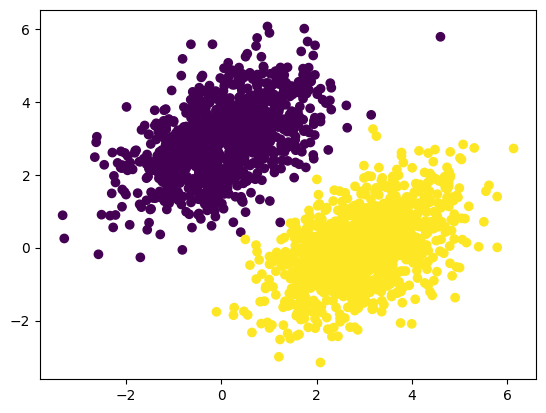

In [59]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [51]:
# The inputs will be 2D points.
input_dim = 2
# The output predictions will be a single score per sample (close to 0
# if the sample is predicted to be in class 0, and close to 1 if the
# sample is predicted to be in class 1).
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [53]:
def model(inputs, W, b):
    return tf.matmul(inputs, W) + b

In [54]:
def mean_squared_error(targets, predictions):
    # per_sample_losses will be a tensor with the same shape as targets
    # and predictions, containing per-sample loss scores.
    per_sample_losses = tf.square(targets - predictions)
    # We need to average these per-sample loss scores into a single
    # scalar loss value: reduce_mean does this.
    return tf.reduce_mean(per_sample_losses)

In [55]:
learning_rate = 0.1

# Wraps the function in a tf.function decorator to speed it up
@tf.function(jit_compile=True)
def training_step(inputs, targets, W, b):
    # Forward pass, inside of a gradient tape scope
    with tf.GradientTape() as tape:
        predictions = model(inputs, W, b)
        loss = mean_squared_error(predictions, targets)
    # Retrieves the gradient of the loss with regard to weights
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Updates the weights
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

In [56]:
for step in range(40):
    loss = training_step(inputs, targets, W, b)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 1.5178
Loss at step 1: 0.2473
Loss at step 2: 0.1242
Loss at step 3: 0.1032
Loss at step 4: 0.0950
Loss at step 5: 0.0889
Loss at step 6: 0.0834
Loss at step 7: 0.0785
Loss at step 8: 0.0739
Loss at step 9: 0.0698
Loss at step 10: 0.0660
Loss at step 11: 0.0626
Loss at step 12: 0.0594
Loss at step 13: 0.0566
Loss at step 14: 0.0539
Loss at step 15: 0.0515
Loss at step 16: 0.0494
Loss at step 17: 0.0474
Loss at step 18: 0.0455
Loss at step 19: 0.0439
Loss at step 20: 0.0423
Loss at step 21: 0.0409
Loss at step 22: 0.0397
Loss at step 23: 0.0385
Loss at step 24: 0.0374
Loss at step 25: 0.0365
Loss at step 26: 0.0356
Loss at step 27: 0.0348
Loss at step 28: 0.0340
Loss at step 29: 0.0334
Loss at step 30: 0.0328
Loss at step 31: 0.0322
Loss at step 32: 0.0317
Loss at step 33: 0.0312
Loss at step 34: 0.0308
Loss at step 35: 0.0304
Loss at step 36: 0.0300
Loss at step 37: 0.0297
Loss at step 38: 0.0294
Loss at step 39: 0.0291


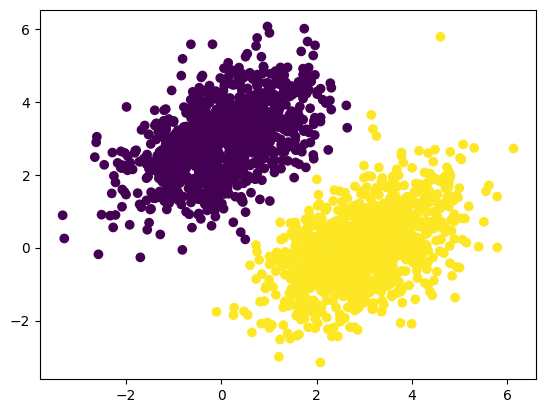

In [60]:
predictions = model(inputs, W, b)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

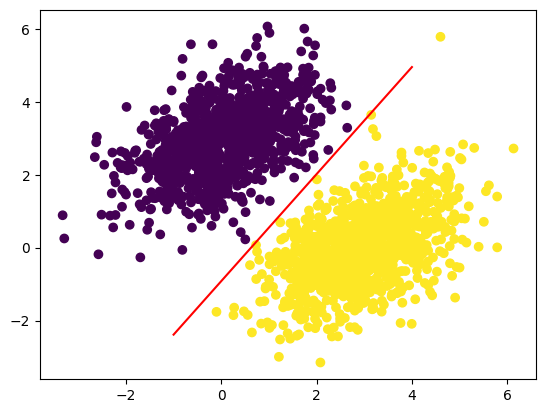

In [61]:
# Generates 100 regularly spaced numbers between -1 and 4, which we
# will use to plot our line
x = np.linspace(-1, 4, 100)
# This is our line's equation.
y = -W[0] / W[1] * x + (0.5 - b) / W[1]
# Plots our line (`"-r"` means "plot it as a red line")
plt.plot(x, y, "-r")
# Plots our model's predictions on the same plot
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

# Introduction to PyTorch


## First steps with PyTorch


### Tensors and parameters in PyTorch


In [8]:
import torch
torch.ones(size=(2, 1))
torch.zeros(size=(2, 1))
torch.tensor([1, 2, 3], dtype=torch.float32)
torch.normal(mean=torch.zeros(size=(3, 1)), std=torch.ones(size=(3, 1)))
torch.rand(3, 1)

tensor([[0.5258],
        [0.2771],
        [0.2916]])

In [11]:
x = torch.zeros(size=(2, 1))
x[0, 0] = 1.

p = torch.nn.parameter.Parameter(data=x)
p

Parameter containing:
tensor([[1.],
        [0.]], requires_grad=True)

### Tensor operations: Doing math in PyTorch


In [19]:
a = torch.ones((2, 2))
# Takes the square, same as np.square
b = torch.square(a)
# # Takes the square root, same as np.sqrt
c = torch.sqrt(a)
# # Adds two tensors (element-wise)
d = b + c
# # Takes the product of two tensors (see chapter 2), same as np.matmul
e = torch.matmul(a, b)
# # Concatenates a and b along axis 0, same as np.concatenate
f = torch.cat((a, b), dim=1)
f

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [20]:
def dense(inputs, W, b):
    return torch.nn.relu(torch.matmul(inputs, W) + b)

### Computing gradients with PyTorch


In [45]:
input_var = torch.tensor(3.0, requires_grad=True)
result = torch.square(input_var)
# result = input_var * 3 + 5
result.backward()
gradient = input_var.grad
gradient

tensor(6.)

In [46]:
input_var.grad = None
result = torch.square(input_var)
result.backward()
input_var.grad

tensor(6.)

## A linear classifier in pure PyTorch

In [71]:
import numpy as np

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    # Generates the first class of points: 1,000 random 2D points with
    # specified "mean" and "covariance matrix." Intuitively, the
    # "covariance matrix" describes the shape of the point cloud, and
    # the "mean" describes its position in the plane. `cov=[[1,
    # 0.5],[0.5, 1]]` corresponds to "an oval-like point cloud oriented
    # from bottom left to top right."
    mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    # Generates the other class of points with a different mean and the
    # same covariance matrix (point cloud with a different position and
    # the same shape)
    mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack(
    (
        np.zeros((num_samples_per_class, 1), dtype="float32"),
        np.ones((num_samples_per_class, 1), dtype="float32"),
    )
)

In [74]:
input_dim = 2
output_dim = 1

W = torch.rand(input_dim, output_dim, requires_grad=True)
b = torch.zeros(output_dim, requires_grad=True)

In [75]:
def model(inputs, W, b):
    return torch.matmul(inputs, W) + b

In [76]:
def mean_squared_error(targets, predictions):
    per_sample_losses = torch.square(targets - predictions)
    return torch.mean(per_sample_losses)

In [77]:
learning_rate = 0.1

def training_step(inputs, targets, W, b):
    # Forward pass
    predictions = model(inputs)
    loss = mean_squared_error(targets, predictions)
    # Computes gradients
    loss.backward()
    # Retrieves gradients
    grad_loss_wrt_W, grad_loss_wrt_b = W.grad, b.grad
    with torch.no_grad():
        # Updates weights inside a no_grad scope
        W -= grad_loss_wrt_W * learning_rate
        b -= grad_loss_wrt_b * learning_rate
    # Resets gradients
    W.grad = None
    b.grad = None
    return loss

In [78]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.W = torch.nn.Parameter(torch.rand(input_dim, output_dim))
        self.b = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, inputs):
        return torch.matmul(inputs, self.W) + self.b

model = LinearModel()

In [79]:
torch_inputs = torch.tensor(inputs)
output = model(torch_inputs)

In [80]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [81]:
def training_step(inputs, targets):
    predictions = model(inputs)
    loss = mean_squared_error(targets, predictions)
    loss.backward()
    optimizer.step()
    model.zero_grad()
    return loss

In [82]:
for step in range(40):
    loss = training_step(torch.tensor(inputs), torch.tensor(targets))
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 3.1242
Loss at step 1: 0.3509
Loss at step 2: 0.1443
Loss at step 3: 0.1155
Loss at step 4: 0.1059
Loss at step 5: 0.0988
Loss at step 6: 0.0926
Loss at step 7: 0.0868
Loss at step 8: 0.0816
Loss at step 9: 0.0768
Loss at step 10: 0.0724
Loss at step 11: 0.0684
Loss at step 12: 0.0648
Loss at step 13: 0.0614
Loss at step 14: 0.0583
Loss at step 15: 0.0555
Loss at step 16: 0.0529
Loss at step 17: 0.0506
Loss at step 18: 0.0484
Loss at step 19: 0.0465
Loss at step 20: 0.0446
Loss at step 21: 0.0430
Loss at step 22: 0.0415
Loss at step 23: 0.0401
Loss at step 24: 0.0388
Loss at step 25: 0.0377
Loss at step 26: 0.0366
Loss at step 27: 0.0356
Loss at step 28: 0.0347
Loss at step 29: 0.0339
Loss at step 30: 0.0332
Loss at step 31: 0.0325
Loss at step 32: 0.0318
Loss at step 33: 0.0313
Loss at step 34: 0.0308
Loss at step 35: 0.0303
Loss at step 36: 0.0298
Loss at step 37: 0.0294
Loss at step 38: 0.0291
Loss at step 39: 0.0287


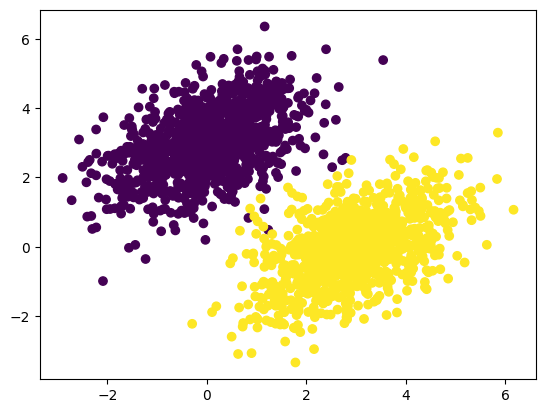

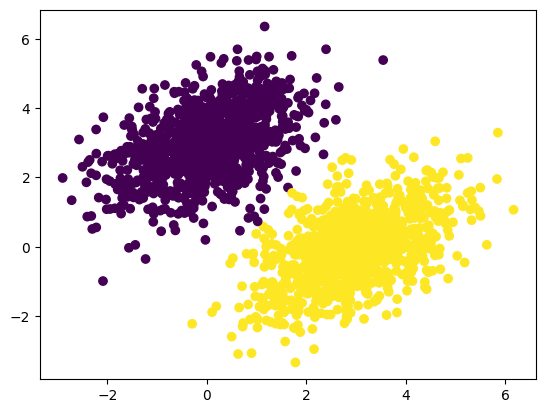

In [85]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

predictions = model(torch_inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

# Introduction to JAX


## First steps with JAX


In [9]:
from jax import numpy as jnp
jnp.ones(shape=(2, 1))
jnp.zeros(shape=(2, 1))
jnp.array([1, 2, 3], dtype="float32")

Array([1., 2., 3.], dtype=float32)

In [10]:
import numpy as np

print(np.random.normal(size=(3,)))
x=np.random.normal(size=(3,))

[ 1.42825739  1.22116865 -0.95873585]


In [11]:
def apply_noise(x, seed):
    np.random.seed(seed)
    x = x * np.random.normal((3,))
    return x

seed = 1337
y = apply_noise(x, seed)
print(y)
seed += 1
z = apply_noise(x, seed)
print(z)

[ 1.57865312 -0.2904075   1.40135871]
[ 2.27050119 -0.4176792   2.01550713]


In [12]:
import jax

seed_key = jax.random.key(1337)

seed_key = jax.random.key(0)
jax.random.normal(seed_key, shape=(3,))

Array([ 1.6226422 ,  2.0252647 , -0.43359444], dtype=float32)

In [13]:
seed_key = jax.random.key(123)
jax.random.normal(seed_key, shape=(3,))

Array([1.6359469 , 0.8408094 , 0.02212393], dtype=float32)

In [14]:
jax.random.normal(seed_key, shape=(3,))

Array([1.6359469 , 0.8408094 , 0.02212393], dtype=float32)

In [15]:
seed_key = jax.random.key(123)
jax.random.normal(seed_key, shape=(3,))

new_seed_key = jax.random.split(seed_key, num=1)[0]
jax.random.normal(new_seed_key, shape=(3,))

Array([-0.49093357, -0.9478693 , -1.775197  ], dtype=float32)

In [16]:
x = jnp.array([1, 2, 3], dtype="float32")
new_x = x.at[0].set(10)
print(new_x)

[10.  2.  3.]


#### Tensor operations: Doing math in JAX


In [17]:
a = jnp.ones((2, 2))
# Takes the square
b = jnp.square(a)
print(b)
# Takes the square root
c = jnp.sqrt(a)
# Adds two tensors (element-wise)
d = b + c
print(d)
# Takes the product of two tensors (see chapter 2)
e = jnp.matmul(a, b)
print(e)
# Multiplies two tensors (element-wise)
e *= d
print(e)

[[1. 1.]
 [1. 1.]]
[[2. 2.]
 [2. 2.]]
[[2. 2.]
 [2. 2.]]
[[4. 4.]
 [4. 4.]]


In [18]:
def dense(inputs, W, b):
    return jax.nn.relu(jnp.matmul(inputs, W) + b)

@jax.jit
def dense(inputs, W, b):
    return jax.nn.relu(jnp.matmul(inputs, W) + b)

#### Computing gradients with JAX


In [19]:
def compute_loss(input_var):
    return jnp.square(input_var)

In [20]:
grad_fn = jax.grad(compute_loss)

In [21]:
input_var = jnp.array(3.0)
grad_of_loss_wrt_input_var = grad_fn(input_var)
print(grad_of_loss_wrt_input_var)

6.0


In [22]:
grad_fn = jax.value_and_grad(compute_loss)
output, grad_of_loss_wrt_input_var = grad_fn(input_var)
print(output, grad_of_loss_wrt_input_var)

9.0 6.0


## A linear classifier in pure JAX

In [24]:
def model(inputs, W, b):
    return jnp.matmul(inputs, W) + b

def mean_squared_error(targets, predictions):
    per_sample_losses = jnp.square(targets - predictions)
    return jnp.mean(per_sample_losses)

In [27]:
def compute_loss(state, inputs, targets):
    W, b = state
    predictions = model(inputs, W, b)
    loss = mean_squared_error(targets, predictions)
    return loss

In [29]:
grad_fn = jax.value_and_grad(compute_loss)

In [38]:
import numpy as np

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    # Generates the first class of points: 1,000 random 2D points with
    # specified "mean" and "covariance matrix." Intuitively, the
    # "covariance matrix" describes the shape of the point cloud, and
    # the "mean" describes its position in the plane. `cov=[[1,
    # 0.5],[0.5, 1]]` corresponds to "an oval-like point cloud oriented
    # from bottom left to top right."
    mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    # Generates the other class of points with a different mean and the
    # same covariance matrix (point cloud with a different position and
    # the same shape)
    mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack(
    (
        np.zeros((num_samples_per_class, 1), dtype="float32"),
        np.ones((num_samples_per_class, 1), dtype="float32"),
    )
)

In [39]:
learning_rate = 0.1

# We use the jax.jit decorator to take advantage of XLA compilation.
@jax.jit
def training_step(inputs, targets, W, b):
    # Computes the forward pass and backward pass in one go
    loss, grads = grad_fn((W, b), inputs, targets)
    grad_wrt_W, grad_wrt_b = grads
    # Updates W and b
    W = W - grad_wrt_W * learning_rate
    b = b - grad_wrt_b * learning_rate
    # Make sure to return the new values of W and b in addition to the
    # loss!
    return loss, W, b

In [40]:
input_dim = 2
output_dim = 1

W = jax.numpy.array(np.random.uniform(size=(input_dim, output_dim)))
b = jax.numpy.array(np.zeros(shape=(output_dim,)))
state = (W, b)
for step in range(40):
    loss, W, b = training_step(inputs, targets, W, b)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 5.9601
Loss at step 1: 0.7634
Loss at step 2: 0.2362
Loss at step 3: 0.1484
Loss at step 4: 0.1272
Loss at step 5: 0.1166
Loss at step 6: 0.1083
Loss at step 7: 0.1009
Loss at step 8: 0.0942
Loss at step 9: 0.0881
Loss at step 10: 0.0825
Loss at step 11: 0.0774
Loss at step 12: 0.0728
Loss at step 13: 0.0686
Loss at step 14: 0.0647
Loss at step 15: 0.0612
Loss at step 16: 0.0580
Loss at step 17: 0.0551
Loss at step 18: 0.0524
Loss at step 19: 0.0500
Loss at step 20: 0.0477
Loss at step 21: 0.0457
Loss at step 22: 0.0439
Loss at step 23: 0.0422
Loss at step 24: 0.0407
Loss at step 25: 0.0393
Loss at step 26: 0.0380
Loss at step 27: 0.0368
Loss at step 28: 0.0358
Loss at step 29: 0.0348
Loss at step 30: 0.0339
Loss at step 31: 0.0331
Loss at step 32: 0.0324
Loss at step 33: 0.0317
Loss at step 34: 0.0311
Loss at step 35: 0.0306
Loss at step 36: 0.0301
Loss at step 37: 0.0296
Loss at step 38: 0.0292
Loss at step 39: 0.0288


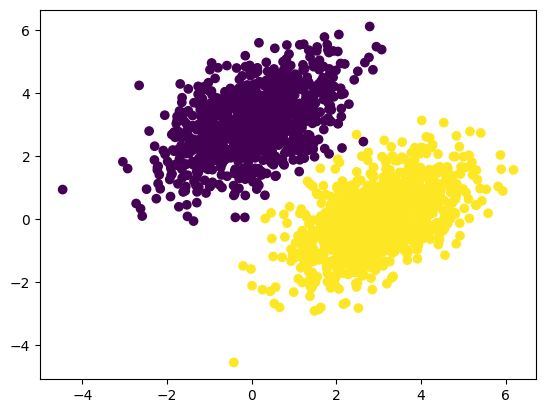

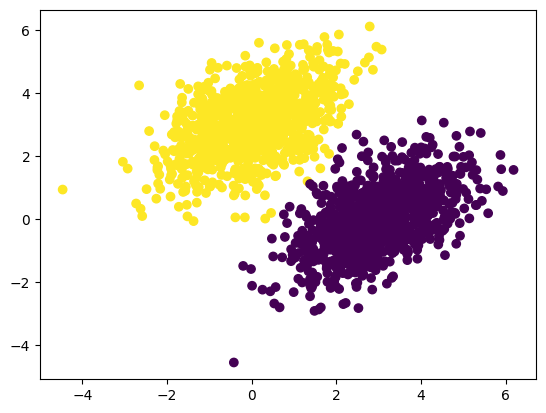

In [43]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

predictions = model(inputs, W, b)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] <= 0.5)
plt.show()